In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from datetime import timedelta
import os
import pickle
from timeit import default_timer as timer
from datetime import timedelta
from IPython.display import clear_output

import gym

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential, optimizers
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
# tf.config.list_physical_devices(device_type='GPU')

In [2]:
seed = 1
random.seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed) # 为了禁止hash随机化，使得实验可复现。

tf.random.set_seed(seed)
# tensorflow 如何设置在GPU上能够复现结果还不太清楚怎么弄

# Replay Memory

In [2]:
class ExperienceReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        
    def add(self, transition):
        self.memory.append(transition)
        if len(self.memory) > self.capacity:
            del self.memory[0]

    def sample(self, batch_size):
        sub_buffer = random.sample(self.memory, batch_size)
        return sub_buffer
    
    def __len__(self):
        return len(self.memory)   

# Network

In [3]:
class DQNMLP(keras.Model):
    def __init__(self, action_dim):
        super(DQNMLP, self).__init__()
        
        self.action_dim = action_dim
        self.fc1 = layers.Dense(64)
        self.fc2 = layers.Dense(128)
        self.fc3 = layers.Dense(64)
        self.fc4 = layers.Dense(self.action_dim)
        
    def call(self, obs, training=None):  # obs is set to be tensor before inputing the model
        '''
        training参数主要是BatchNormalization和DropOut层
        '''
        x = tf.nn.relu(self.fc1(obs))
        x = tf.nn.relu(self.fc2(x))
        x = tf.nn.relu(self.fc3(x))
        x = self.fc4(x)
        
        return x       

# Config

In [4]:
class Config(object):
    def __init__(self):
        
        #epsilon variables    espislon-greedy exploration
        self.epsilon_start = 0.1   # 1
        self.epsilon_final = 0.1   # 0.01
        self.epsilon_decay = 30000
        '''
        epsilon随着traning step增加递减, 探索得越来越少，
        但是这不是对于SARSA来说才需要的吗，对于Q-learning，behavior policy可以保持一定的探索程度
        留个疑问，之后看看其他大佬的代码是怎么处理这一部分的
        目前我的想法是：因为在DQN里target_model其实是拷贝model的参数，所以model的epsilon是需要逐渐变小的（为了达到最优）
        如果不用model来收集数据，而是用另一个策略（比如随机的策略），那么model可以不用考虑探索（epsilon=0）
        但是用完全随机的策略而不是用逐渐变好的策略（假设训练是有效的）作为behavior policy的缺点在于
        对于好的action不能更多的采样来估计准它的value, 而且又要额外多用一个策略，不如就用model来收集数据
        '''
        self.epsilon_by_step = lambda step: self.epsilon_final + (self.epsilon_start - self.epsilon_final) * np.exp(-1. * step / self.epsilon_decay)
        
        # learning control variables
        self.gamma = 0.99
        self.lr = 1e-4
        self.max_steps = int(1e6)
        self.batch_size = 32
        self.target_net_update_freq = 1000
        self.training_env_seed = 123
        
        
        #memory
        self.experience_replay_size = int(1e5)
        self.learn_start = 1000    

# Agent

In [5]:
class DQNAgent(object):
    def __init__(self, env_name=None, network=None, eval_mode=False, config=None):
        '''
        agent里的self.env用来训练
        评估的环境在外面重新创建一个： env = gym.make(self.env_name)
        '''
        self.env_name = env_name
        self.env = gym.make(env_name)
        self.env.seed(config.training_env_seed)
        
        self.action_dim = self.env.action_space.n
        
        self.eval_mode = eval_mode
        
        self.gamma = config.gamma
        self.lr = config.lr
        self.target_net_update_freq = config.target_net_update_freq
        self.experience_replay_size = config.experience_replay_size
        self.learn_start = config.learn_start
        self.batch_size = config.batch_size
        
        self.memory = ExperienceReplayMemory(self.experience_replay_size)
        
        self.network = network
        
        self.model = self.network(self.action_dim)
        self.target_model = self.network(self.action_dim)
        self.target_model.set_weights(self.model.get_weights())

        
        exponential_decay = optimizers.schedules.ExponentialDecay(initial_learning_rate=self.lr, decay_steps=10000, decay_rate=1)
        self.optimizer = optimizers.Adam(learning_rate=exponential_decay)
#         self.optimizer = optimizers.Adam(learning_rate=self.lr)
        
        self.loss = tf.losses.Huber(delta=1.)
        
        self.update_count = 0
        self.losses = []
        self.rewards = []
        self.episode_length = []
        
    
    def train(self, step=0):
        
        if self.eval_mode:
            return None
        
        if step < self.learn_start:
            return None
        
        transitions = self.memory.sample(self.batch_size)
        obses_t, actions, rewards, obses_tp1, dones = zip(*transitions)
            
        obses_t = tf.convert_to_tensor(obses_t, dtype=tf.float32)
        actions = tf.squeeze(tf.convert_to_tensor(actions, dtype=tf.int32))
        rewards = tf.convert_to_tensor(rewards, dtype=tf.float32)
        obses_tp1 = tf.convert_to_tensor(obses_tp1, dtype=tf.float32)
        dones = tf.convert_to_tensor(dones, dtype=tf.float32)
        
    
        with tf.GradientTape() as tape:
            # Q(s,a)
            q_vals = self.model(obses_t)
            indices = tf.stack([tf.range(actions.shape[0]), actions], axis=-1)
            chosen_q_vals = tf.gather_nd(q_vals, indices=indices)
            
            q_tp1_vals = tf.reduce_max(self.target_model(obses_tp1), axis=-1)
            
            targets = tf.stop_gradient(reward + self.gamma * q_tp1_vals * (1 - dones))
            
            loss = self.loss(chosen_q_vals, targets)
            
        grads = tape.gradient(loss, self.model.trainable_variables)
#         grads = [tf.clip_by_value(grad, -1, 1) for grad in grads]

        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
        
        self.losses.append(loss.numpy())
        
        
        # update target model
        self.update_count += 1
        if self.update_count % self.target_net_update_freq == 0:
            self.target_model.set_weights(self.model.get_weights())
            
        '''
        也可以使用soft update: traget_weight = (1 - 0.999) * model_weight + 0.999 * target_weight
        '''
#         params = self.model.get_weights()
#         target_params = self.target_model.get_weights()
#         for idx in range(len(params)):
#             target_params[idx] = (1 - 0.999) * params[idx] + 0.999 * target_params[idx]
#         self.target_model.set_weights(target_params)
        
    
    def get_action(self, obs, eps=0.1, training=None):
        if np.random.random() >= eps or self.eval_mode:
            obs = np.expand_dims(obs, 0)
            obs = tf.convert_to_tensor(obs, dtype=tf.float32)  # 要指定type，不然会报warning
            a = tf.stop_gradient(tf.argmax(self.model(obs, training=training), axis=-1))
            return a.numpy()[0]
        else:
            return np.random.randint(0, self.action_dim)
    
    def eval_(self, env, n_trajs):
        self.eval_mode = True
        
        for _ in range(n_trajs):
            episode_return = 0
            episode_length = 0
            obs = env.reset()
            for _ in range(10000):
                a = self.get_action(obs, training=self.eval_mode)  # 这个是training还是eval模式的逻辑有点搞。。。
                obs, reward, done, info = env.step(a)
                episode_return += reward
                episode_length += 1

                if done:
                    self.rewards.append(episode_return)
                    self.episode_length.append(episode_length)
                    break

        # print('eval {} trajs, mean return: {}'.format(n_trajs, np.mean(episode_returns)))
        
        self.eval_mode = False
        return np.mean(self.rewards[-n_trajs:]), np.max(self.rewards[-n_trajs:]), np.mean(self.episode_length[-n_trajs:]), np.max(self.episode_length[-n_trajs:])

    
    def save_w(self):
        self.model.save_weights('./model_weights.ckpt')
    
    
    def load_w(self):
        fname_model = './model_weights.ckpt'

        if os.path.isfile(fname_model):
            self.model.load_weights(fname_model)
            self.target_mdoel.load_weights(fname_model)


    def save_replay(self):
        pickle.dump(self.memory, open('./exp_replay_agent.dump', 'wb'))

    def load_replay(self):
        fname = './exp_replay_agent.dump'
        if os.path.isfile(fname):
            self.memory = pickle.load(open(fname, 'rb'))


    def render(self, env):
        self.eval_mode = True
        obs = env.reset()
        for _ in range(10000):
            env.render()
            a = self.get_action(obs, training=self.eval_mode)
            obs, reward, done, info = env.step(a)
            if done:
                break
        self.eval_mode = False

# Training Loop

## tensorflow跑，同样的网络结构，同样的优化器，同样的方法，跑得比pytorch慢，跑的training step要多，还不是很稳定。。。

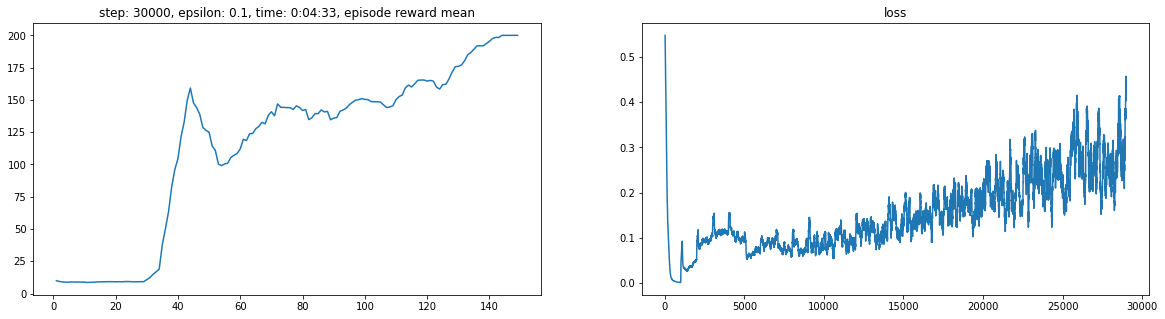

step: 31000, epsilon: 0.1, lr: 9.999999747378752e-05, time: 0:04:42
episode reward mean: 200.0, epsisode reward max: 200.0, episode length mean: 200.0, episode length max: 200, loss: 0.33741289377212524
step: 32000, epsilon: 0.1, lr: 9.999999747378752e-05, time: 0:04:51
episode reward mean: 200.0, epsisode reward max: 200.0, episode length mean: 200.0, episode length max: 200, loss: 0.5419516563415527
step: 33000, epsilon: 0.1, lr: 9.999999747378752e-05, time: 0:05:01
episode reward mean: 200.0, epsisode reward max: 200.0, episode length mean: 200.0, episode length max: 200, loss: 0.27645039558410645
step: 34000, epsilon: 0.1, lr: 9.999999747378752e-05, time: 0:05:10
episode reward mean: 200.0, epsisode reward max: 200.0, episode length mean: 200.0, episode length max: 200, loss: 0.11195182800292969
step: 35000, epsilon: 0.1, lr: 9.999999747378752e-05, time: 0:05:20
episode reward mean: 200.0, epsisode reward max: 200.0, episode length mean: 200.0, episode length max: 200, loss: 0.6685

In [7]:
name = 'CartPole-v0'
env_eval = gym.make(name)
env_eval.seed(seed)


config = Config()

start = timer()

dqn_agent = DQNAgent(env_name=name, network=DQNMLP, config=config)

obs = dqn_agent.env.reset()
for step in range(1, config.max_steps+1):
    epsilon = config.epsilon_by_step(step)
    
    action = dqn_agent.get_action(obs, epsilon)
    pre_obs = obs
    obs, reward, done, _ = dqn_agent.env.step(action)
    
    dqn_agent.memory.add((pre_obs, action, reward, obs, done))
    
    dqn_agent.train(step)
    
    if done:
        obs = dqn_agent.env.reset()
        
    if step % 1000 == 0:
        mean_returns, max_returns, mean_lengths, max_lengths = dqn_agent.eval_(env_eval, 5)
        
        print('step: {}, epsilon: {}, lr: {}, time: {}'.format(step, epsilon, dqn_agent.optimizer.lr(step).numpy(), timedelta(seconds=int(timer()-start))))
        print('episode reward mean: {}, epsisode reward max: {}, episode length mean: {}, episode length max: {}, loss: {}'.format(
            mean_returns,
            max_returns,
            mean_lengths,
            max_lengths,
            np.array(dqn_agent.losses[-10:]).mean()))
    
#     print('=========================================')
#     print([(param.data.max().item(), param.data.min().item(), param.grad.data.max().item(), param.grad.data.min().item()) for param in dqn_agent.model.parameters()])
#     print('=========================================')
    
    if step % 10000 == 0:
        clear_output(True)
        
        clear_output(True)
        plt.figure(figsize=(20, 5))
        plt.subplot(121)
        plt.title('step: {}, epsilon: {}, time: {}, episode reward mean'.format(step, epsilon, timedelta(seconds=int(timer()-start))))
        plt.plot(pd.Series(dqn_agent.rewards).rolling(10, 2).mean())
        plt.subplot(122)
        plt.title('loss')
        plt.plot(pd.Series(dqn_agent.losses).rolling(100, 20).mean())
        plt.show()
    
    if np.array(dqn_agent.rewards[-50:]).mean() > 195:  # 一开始会报一个warning: RuntimeWarning: Mean of empty slice， 可以忽略
        print('a new render begins')
        mean_returns, max_returns, mean_lengths, max_lengths = dqn_agent.eval_(env_eval, 100)
        print('step: {}, epsilon: {}, time: {}'.format(step, epsilon, timedelta(seconds=int(timer()-start))))
        print('episode reward mean: {}, epsisode reward max: {}, episode length mean: {}, episode length max: {}'.format(
            mean_returns,
            max_returns,
            mean_lengths,
            max_lengths))
        if mean_returns > 195: 
            print('Solved!')
            break 
        
# dqn_agent.render(env_eval)

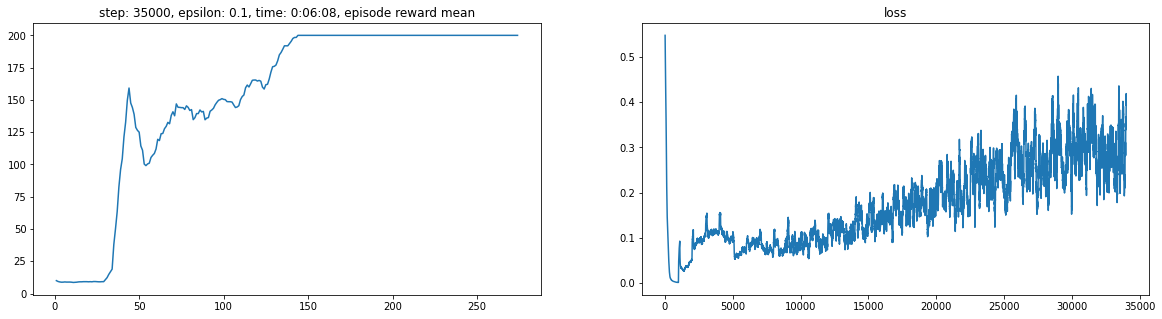

In [8]:
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.title('step: {}, epsilon: {}, time: {}, episode reward mean'.format(step, epsilon, timedelta(seconds=int(timer()-start))))
plt.plot(pd.Series(dqn_agent.rewards).rolling(10, 2).mean())
plt.subplot(122)
plt.title('loss')
plt.plot(pd.Series(dqn_agent.losses).rolling(100, 20).mean())
plt.show()

In [9]:
dqn_agent.model.save_weights('./dqn_cartpole.ckpt')

In [11]:
dqn_agent.render(env_eval)

# 加载模型

首先还是要把1-4跑一遍，然后执行下面的代码

In [7]:
name = 'CartPole-v0'
env_eval = gym.make(name)

config = Config()
dqn_agent = DQNAgent(env_name=name, network=DQNMLP, eval_mode=True, config=config)
dqn_agent.model.load_weights('./dqn_cartpole.ckpt')

dqn_agent.render(env_eval)